#### setup

In [1]:
import pandas as pd
import numpy as np
import warnings
from itertools import product, combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
import itertools
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def load_df_from_file(verbose=True):
    """
    Load the raw dataset with minor mods
    """
    file_path = './event_labels_1_18_2025_last_N_days.csv'
    data = pd.read_csv(file_path)
    
    if verbose is True:
        print(f"num unique artists - {len(data.act.unique())}")

    # Replace inf and -inf with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    return data

#### run training and testing for a single artist pair and then analyze the models

num unique artists - 955
All Artist Combos Length - 909162
Error improve 7.6923076923076925%
Original predictions vector:
[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Regularized (improved) predictions vector:
[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
True vector:
[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


,date,act,average_price,median_price,lowest_price,highest_price,alpha,beta,event_id
0,2023-07-15 19:00:00,The Avett Brothers,202.642857,173.571429,57.285714,1564.571429,1.409503,13.206386,0
767,2023-07-07 19:00:00,The Avett Brothers,321.571429,236.642857,162.428571,1068.642857,0.522309,2.451899,763
15332,2023-09-23 20:00:00,The Avett Brothers,196.785714,175.142857,56.785714,543.714286,1.107998,2.745687,15003
9186,2023-09-30 19:00:00,Dropkick Murphys,103.071429,89.785714,66.142857,729.642857,0.860493,14.600081,9023
2778,2023-08-25 19:00:00,The Avett Brothers,153.285714,134.857143,48.071429,832.428571,1.481961,9.565843,2735
21909,2024-02-25 19:00:00,Dropkick Murphys,252.428571,188.285714,99.142857,746.000000,0.577032,1.858009,21446
9201,2023-10-17 19:00:00,Dropkick Murphys,109.857143,92.142857,57.214286,846.785714,0.902949,12.640062,9034
21903,2024-02-14 19:00:00,Dropkick Murphys,145.000000,122.071429,90.642857,552.071429,0.682590,5.111802,21440
2642,2023-06-20 19:30:00,The Avett Brothers,165.571429,157.714286,112.428571,662.785714,1.883518,17.622542,2599
11974,2023-10-10 19:00:00,Dropkick Murphys,191.428571,139.928571,56.357143,746.571429,0.662540,2.723036,11711


Overall Performance:
Total Correct Predictions with Subset: 11/13
Total Correct Predictions with Subset + Constants: 12/13


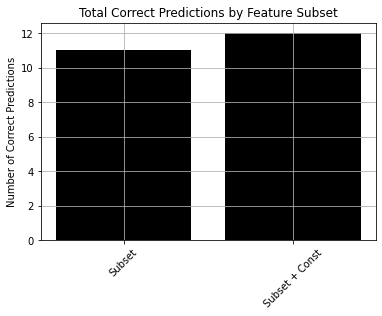

Num improved: 1
Num degraded: 0
Original model accuracy:
0.8461538461538461
Regularized model accuracy:
0.9230769230769231


In [3]:
data = load_df_from_file()
X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
y_full = data["act"] 

art2 = "The Avett Brothers"
art1 = "Dropkick Murphys"

# Define the feature subsets
subset_indices = [0, 1, 2, 3, 4, 5]  

# Create the Cartesian product - this has symmetrical duplicates
# oddly the accuracies arent the same
cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])

# Remove the rows where act1 == act2 to avoid duplicates
df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']]

# Reset the index for df2
df_act_cartesian_product = df_act_cartesian_product.reset_index(drop=True)
print(f"All Artist Combos Length - {len(df_act_cartesian_product)}")

act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]

# Feature names for subsets
feature_names_full = X_full.columns
feature_names_subset1 = feature_names_full[subset_indices]

# Initialize cumulative feature usage counts
total_feature_usage_subset1 = np.zeros(len(subset_indices))
total_feature_usage_subset1_const = np.zeros(len(subset_indices))

# To store results for each pairwise model
results = []

# Initialize counters for total correct predictions
total_correct = {
    'subset': 0,
    'subset_const': 0,
}
total_samples = 0

break_after = 5000
num_iter = 0

all_models = []
all_models_regularization = []

columns_to_correlate = ['average_price', 'median_price', 'lowest_price', 
                        'highest_price', 'alpha', 'beta']
all_correlations = []

# Iterate over each pair of acts
for act_1, act_2 in act_pairs:
    
    if act_2 != art2 or act_1 != art1:
        continue
    
    # Filter data for the current pair of acts
    pair_mask = (y_full == act_1) | (y_full == act_2)
     
    
    X_pair_full = X_full[pair_mask]
    y_pair = y_full[pair_mask].replace({act_1: 0, act_2: 1})  # Binary labels
    
    # Split the data
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_pair_full, y_pair, test_size=0.2, random_state=42
    )
    
    # collect the correlations for the features to the target for each pair dataset
    # ie for each model
    correlations = {col: abs(X_train_full[col].corr(y_train)) for col in columns_to_correlate}
    all_correlations.append(correlations)
    
    # Keep track of total samples
    total_samples += len(y_test)

    # Function to train and evaluate model on a given subset of features
    def train_evaluate_model(X_train, X_test, feature_subset, add_constants=False):
        # Select the subset of features
        X_train_subset = X_train.iloc[:, feature_subset].copy()
        X_test_subset = X_test.iloc[:, feature_subset].copy()
        
        if add_constants:
            # Add 20 constant features with the same value (e.g., zero)
            num_constants = 20
            const_value = 0  # or any constant value
            for i in range(num_constants):
                X_train_subset[f'const_{i}'] = const_value
                X_test_subset[f'const_{i}'] = const_value
        
        # Train the model
        model = RandomForestClassifier(random_state=42, 
                                          class_weight='balanced', 
                                          max_features=3,
                                          max_depth=100,
                                          n_estimators=100)
        model.fit(X_train_subset, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        correct_predictions = np.sum(y_pred == y_test)
        
        return accuracy, correct_predictions, model

    # Train and evaluate models
    # Subset without constants
    acc, correct, model = train_evaluate_model(X_train_full, X_test_full, subset_indices, add_constants=False)
    
        
    # Only Dropkick Murphys vs Avett Brothers
    #####################################
    pct_error1=0
    pct_error2=0
    if act_2 == art2 or act_1 == art1:
        rr = data[pair_mask] 
        a, b, c, d = train_test_split(
            rr, y_pair, test_size=0.2, random_state=42
        )
        #display(b)
        aa1 = model.predict(X_test_full.iloc[:, subset_indices])
        pct_error1 = 100 * (y_test != aa1).sum() / len(y_test)
    #####################################
    
    total_correct['subset'] += correct
    all_models.append(model)

    # Subset with constants
    acc_const, correct_const, model_reg = train_evaluate_model(X_train_full, X_test_full, 
                                                               subset_indices, add_constants=True)
    
    
    # Only Dropkick Murphys vs Avett Brothers
    #####################################
    if act_2 == art2 or act_1 == art1:
        rr = data[pair_mask] 
        a, b, c, d = train_test_split(
            rr, y_pair, test_size=0.2, random_state=42
        )
        #display(b)
        e = X_test_full.copy()
        num_constants = 20
        for i in range(num_constants):
                e[f'const_{i}'] = 0
                
        aa2 = model_reg.predict(e)
        pct_error2 = 100 * (y_test != aa2).sum() / len(y_test)
        if pct_error2 < pct_error1:
            print(f"Error improve {pct_error1-pct_error2}%")
            print("Original predictions vector:")
            print(list(aa1))
            print("Regularized (improved) predictions vector:")
            print(list(aa2))
            print("True vector:")
            print(list(y_test))
            display(b)
    #####################################
    
    total_correct['subset_const'] += correct_const
    all_models_regularization.append(model_reg)

    # Improvement for Subset
    improvement = acc_const - acc

    # Store the results
    results.append({
        "act Pair": f"{act_1} vs {act_2}",
        "Accuracy Subset": acc,
        "Accuracy Subset + Const": acc_const,
        "Improvement Subset": improvement,
        "Number of Test Examples": len(X_test_full),
        "Number of Train Examples": len(X_train_full)
    })
    
        # Collect feature usage counts
    def collect_feature_usage(model, num_original_features):
        # Initialize feature usage counts
        feature_usage = np.zeros(num_original_features)
        
        # Iterate through each tree in the Random Forest model
        for tree in model.estimators_:
            tree_features = tree.tree_.feature
            for feature_used in tree_features:
                if feature_used >= 0 and feature_used < num_original_features:
                    feature_usage[feature_used] += 1
        return feature_usage

    # For Subset 1 without constants
    num_features_subset1 = len(subset_indices)
    model_subset1 = model
    feature_usage_subset1 = collect_feature_usage(model_subset1, num_features_subset1)
    total_feature_usage_subset1 += feature_usage_subset1
    
    # DEBUG
    #print(feature_usage_subset1)

    # For Subset 1 with constants
    model_subset1_const = model_reg
    feature_usage_subset1_const = collect_feature_usage(model_subset1_const, num_features_subset1)
    total_feature_usage_subset1_const += feature_usage_subset1_const

    num_iter += 1
    if num_iter >= break_after:
        break

# Convert results to a DataFrame
ae = pd.DataFrame(results)
ae = ae.sort_values(by='Improvement Subset', ascending=False)
#display(ae)
#results_df.to_csv("results_df_4_28_2024_regularization.csv", index=False)

# Print overall statistics
print("Overall Performance:")
print(f"Total Correct Predictions with Subset: {total_correct['subset']}/{total_samples}")
print(f"Total Correct Predictions with Subset + Constants: {total_correct['subset_const']}/{total_samples}")

# Plotting the bar chart of overall performance
labels = ['Subset', 'Subset + Const']
correct_predictions = [
    total_correct['subset'],
    total_correct['subset_const'],
]

plt.bar(labels, correct_predictions, color=['black', 'black'])
plt.title('Total Correct Predictions by Feature Subset')
plt.ylabel('Number of Correct Predictions')
plt.xticks(rotation=45)
plt.grid()
plt.show()


a = len(ae[ae["Improvement Subset"] > 0])
b = len(ae[ae["Improvement Subset"] < 0])
print("Num improved: " + str(a))
print("Num degraded: " + str(b))
  
print("Original model accuracy:")
print(ae["Accuracy Subset"].mean())
print("Regularized model accuracy:")
print(ae["Accuracy Subset + Const"].mean())

##### feature usage analysis for single artist pair models

['$\\mu_i$', '$\\tilde{\\mu}_i$', '$\\mathrm{Min}_i$', '$\\mathrm{Max}_i$', '$\\alpha_i$', '$\\beta_i$']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


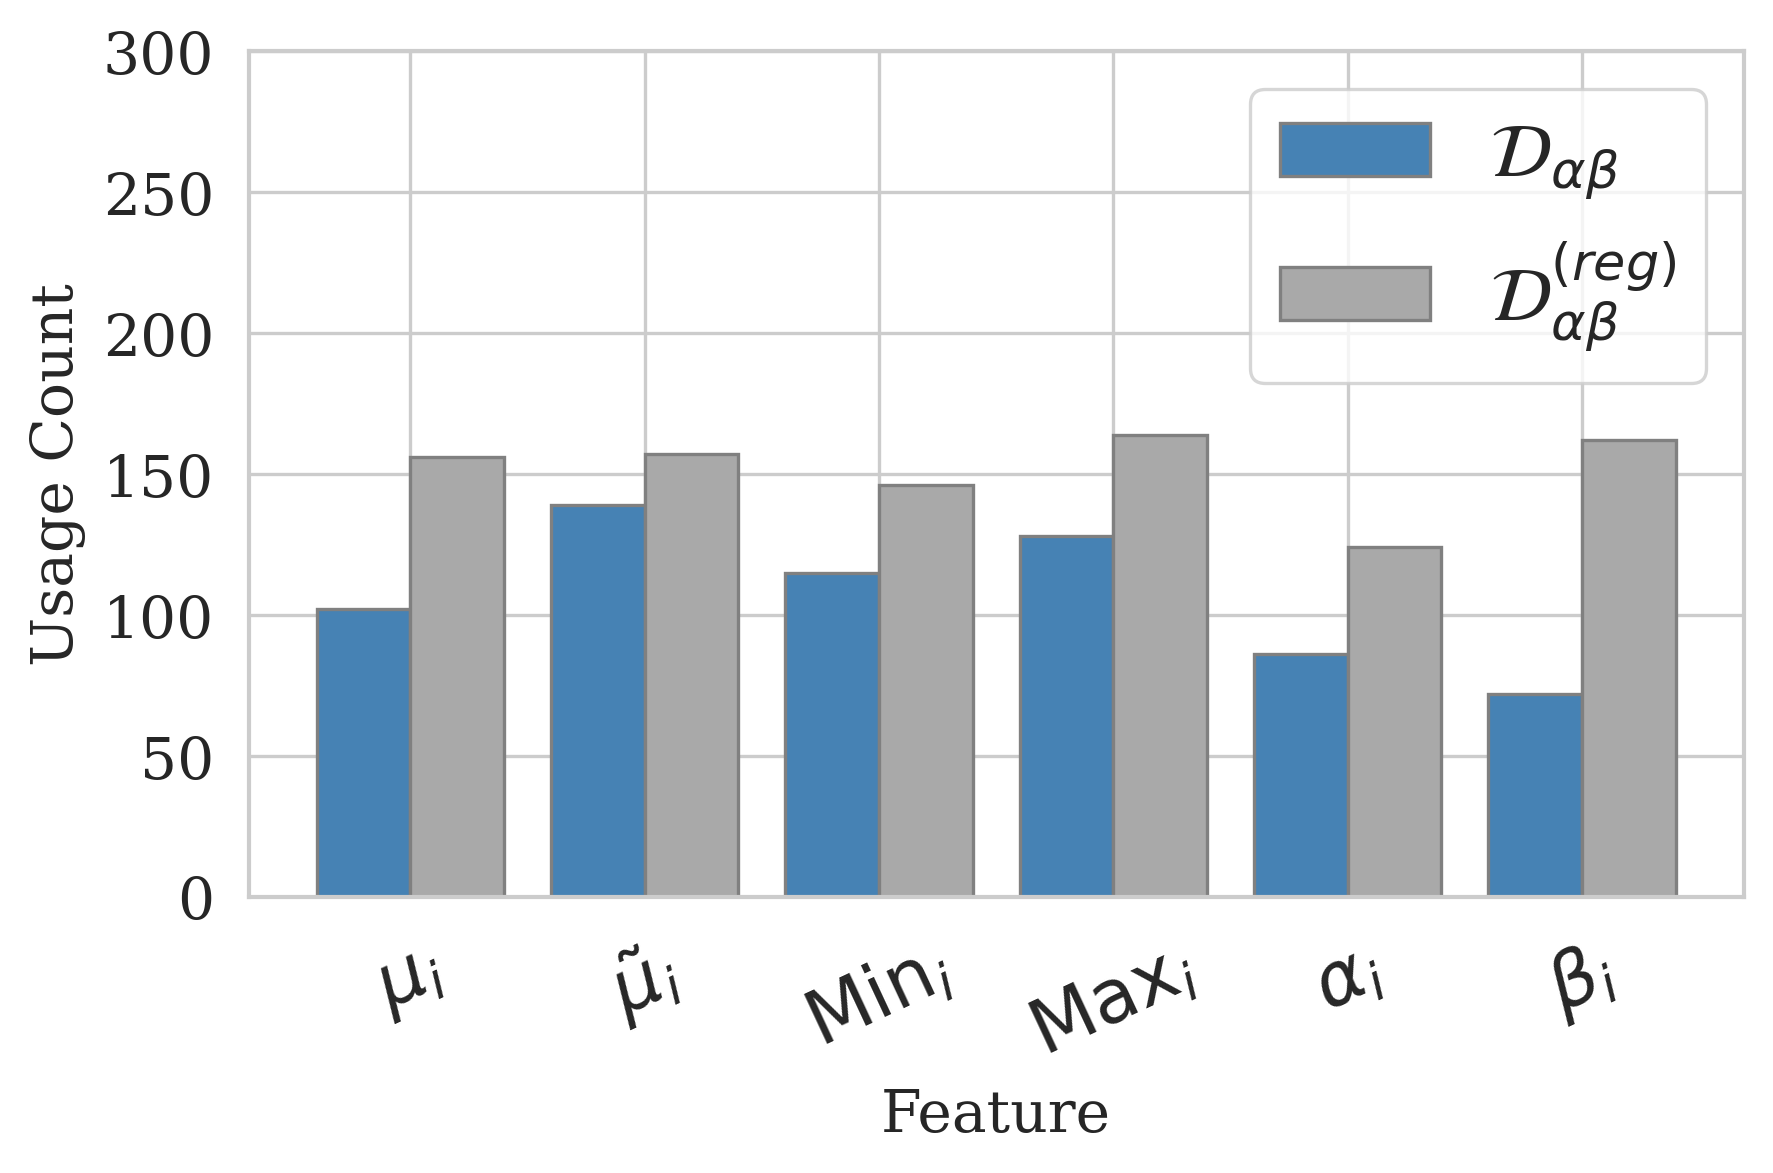

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

fsize = 14  # Base font size for labels and ticks

# --- Data for plotting ---
indices1 = np.arange(len(feature_names_subset1))
subs1 = total_feature_usage_subset1
subs2 = total_feature_usage_subset1_const
fns1 = feature_names_subset1

# Create figure with high DPI and a white background
#plt.figure(figsize=(12, 8), dpi=300, facecolor='white')
plt.figure(dpi=300, facecolor="white")

escaped_strings = []
for s in fns1:
    s = s.replace("average_price", r'$\mu_i$')
    s = s.replace("median_price", r"$\tilde{\mu}_i$")
    s = s.replace("lowest_price", r"$\mathrm{Min}_i$")
    s = s.replace("highest_price", r"$\mathrm{Max}_i$")
    s = s.replace("beta", r"$\beta_i$")
    s = s.replace("alpha", r"$\alpha_i$")
    escaped_strings.append(s)
    
fns1 = escaped_strings
print(fns1)

# Plot the bar charts for feature usage counts
plt.bar(indices1 - 0.2, subs1, width=0.4, label=r'$\mathcal{D}_{\alpha \beta}$',
        color='steelblue', edgecolor='gray', alpha=1)
plt.bar(indices1 + 0.2, subs2, width=0.4, label=r'$\mathcal{D}_{\alpha \beta}^{(reg)}$',
        color='darkgray', edgecolor='gray', alpha=1)

# Label axes using LaTeX formatting and the defined font size
plt.xlabel(r'Feature', fontsize=fsize)
plt.ylabel(r'Usage Count', fontsize=fsize)

# Set x-ticks to show feature names, rotated for clarity
plt.xticks(indices1, fns1, rotation=25, fontsize=18)
plt.yticks(fontsize=fsize)

plt.ylim(0,300)

# Position the legend outside the main plot area
plt.legend(loc='upper right', fontsize=18)

# Adjust layout to minimize whitespace
plt.tight_layout()

# Save the figure in both EPS and PNG formats with high resolution
plt.savefig(
    'dropkick_murphys_avett_brothers_regularization_feature_usage_tickets.eps',
    format='eps',
    dpi=300,
    pad_inches=0,
    bbox_inches='tight'
)

##### estimated beta distribution analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


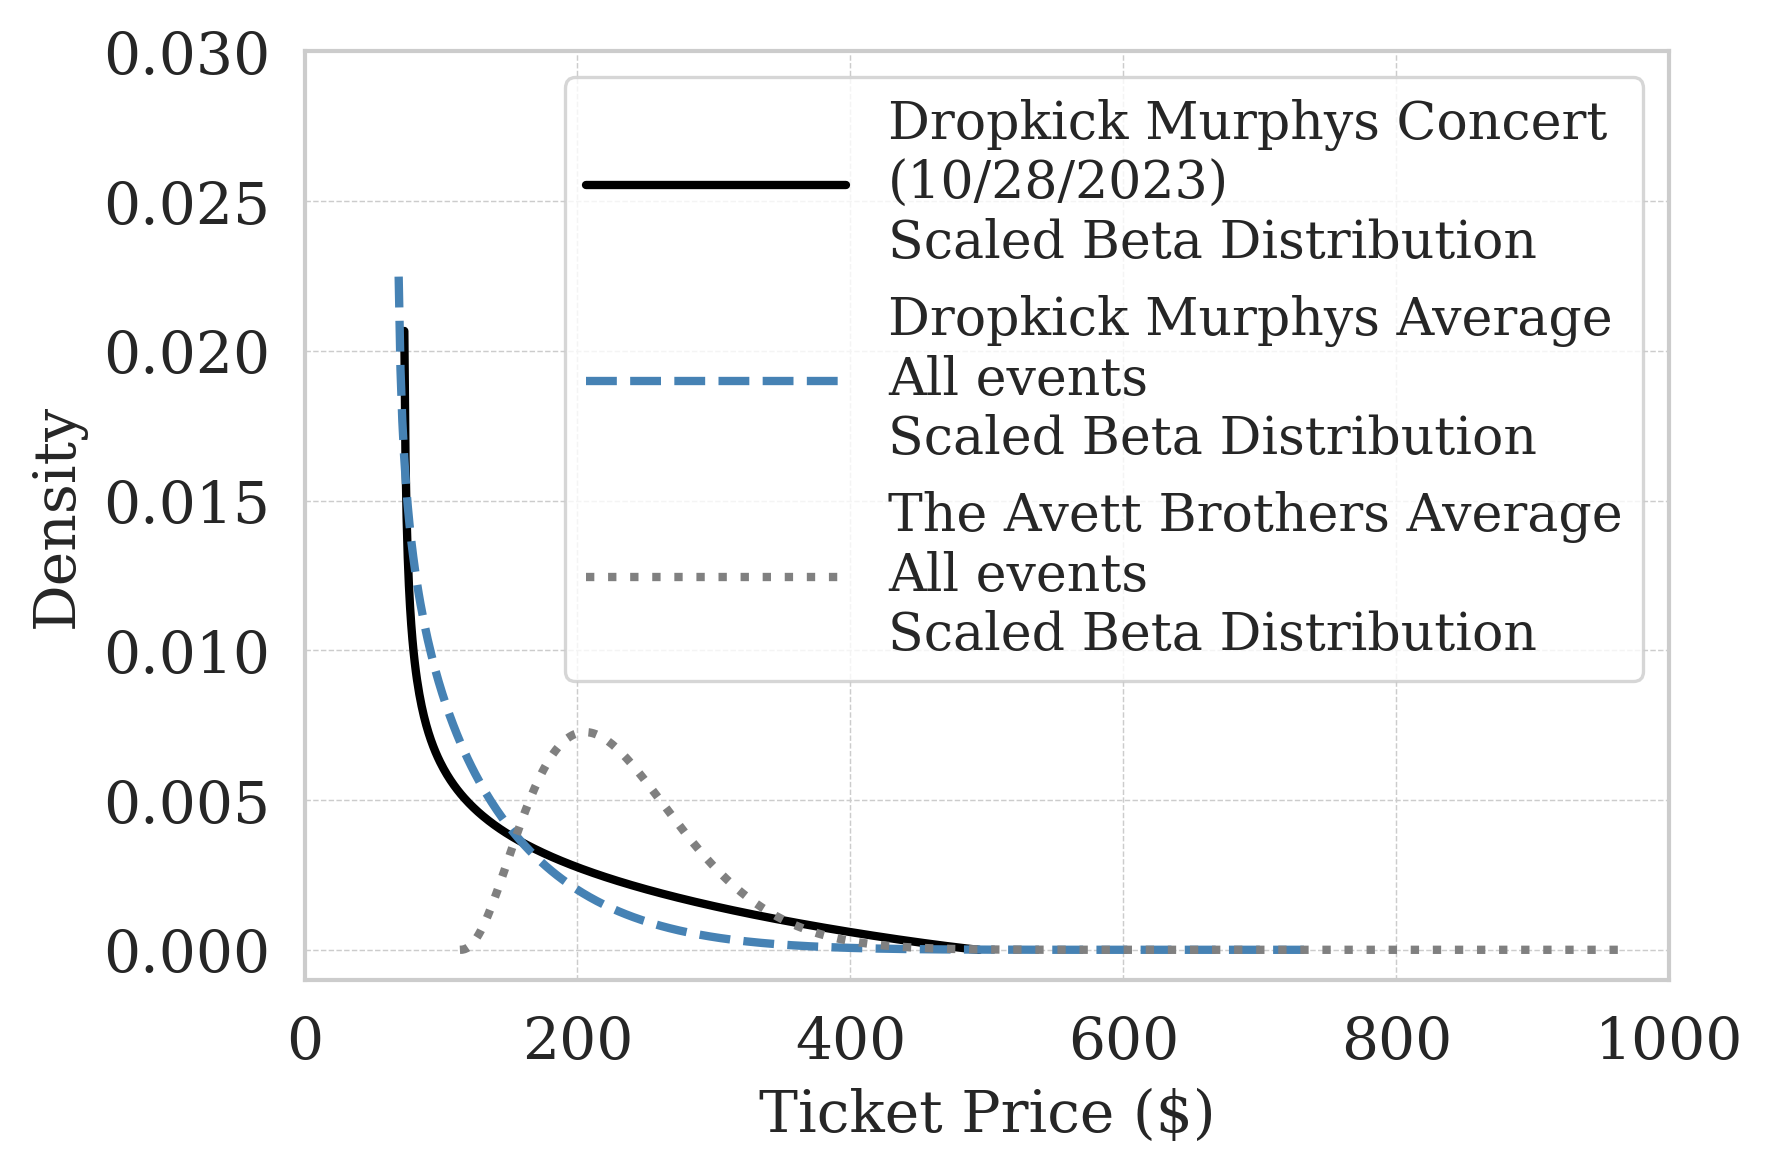

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from scipy.stats import beta
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

fsize = 14

# Define muted blue-gray-black color palette
line_colors = {
    "Event Time Series": "black",
    f"{art1} Average": "#4682B4",
    f"{art2} Average": "grey",
    f"{art1} Median": "#4682B4",
    f"{art2} Median": "grey"
}

# Load full dataset
full_df = load_df_from_file(verbose=False)

# Create subsets:
# 1. Single event time series by event_id
df_event = full_df[full_df.event_id == 8284]

# 2. Averages (mean) for each act
df_bey_avg = full_df[full_df.act == art1].groupby("act").mean().reset_index()
df_sheeran_avg = full_df[full_df.act == art2].groupby("act").mean().reset_index()

# 3. Medians for each act (if needed)
df_bey_med = full_df[full_df.act == art1].groupby("act").median().reset_index()
df_sheeran_med = full_df[full_df.act == art2].groupby("act").median().reset_index()

# Helper function to plot beta PDFs and add vertical lines for mean and median
def plot_series(ax, data, label, linestyle, color):
    if data.empty:
        return
    # Extract parameters
    mean_val = data.average_price.iloc[0]
    median_val = data.median_price.iloc[0]
    min_value = data.lowest_price.iloc[0]
    max_value = data.highest_price.iloc[0]
    alpha_val = data.alpha.iloc[0]
    beta_val = data.beta.iloc[0]
    
    # Generate x values over the price range and scale appropriately
    x = np.linspace(min_value, max_value, 500)
    scale_factor = max_value - min_value
    x_scaled = (x - min_value) / scale_factor
    
    # Ensure positive alpha and beta values
    alpha_val = max(alpha_val, 0.001)
    beta_val = max(beta_val, 0.001)
    
    # Compute the scaled beta distribution PDF
    pdf_vals = beta.pdf(x_scaled, alpha_val, beta_val) / scale_factor
    
    # Plot the PDF curve
    ax.plot(x, pdf_vals, linestyle=linestyle, color=color, linewidth=2, label=label)
    
    # Add vertical lines for average and median of this series
#     ax.axvline(mean_val, color=color, linestyle=linestyle, linewidth=2,
#                label=f"{label} Average = {mean_val:.3f}")
#     ax.axvline(median_val, color=color, linestyle=linestyle, linewidth=4,
#                label=f"{label} Median = {median_val:.3f}")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot each series using distinct line styles for clear differentiation in black and white
plot_series(ax, df_event, f"Dropkick Murphys Concert\n(10/28/2023)\nScaled Beta Distribution", 
            linestyle='-', color=line_colors["Event Time Series"])
plot_series(ax, df_bey_avg, f"{art1} Average\nAll events\nScaled Beta Distribution", 
            linestyle='--', color=line_colors[f"{art1} Average"])
plot_series(ax, df_sheeran_avg, f"{art2} Average\nAll events\nScaled Beta Distribution", 
            linestyle=':', color=line_colors[f"{art2} Average"])

# Set labels, legend, and grid styling
ax.set_xlabel("Ticket Price (\$)", fontsize=fsize)
ax.set_ylabel("Density", fontsize=fsize)
ax.set_xlim(0, 1000)
ax.set_ylim(-.001, .03)
plt.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

# To avoid duplicate legend entries, filter them
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12.5, facecolor='white', frameon=True, handlelength=5)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('dropkick_murphys_avett_brothers_regularization_comparison.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()


##### analysis of original features without scaled beta estimation

,date,act,average_price,median_price,lowest_price,highest_price,alpha,beta,event_id
8398,2023-10-28 18:00:00,Dropkick Murphys,175.642857,141.357143,72.285714,494.285714,0.675917,2.083805,8284


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


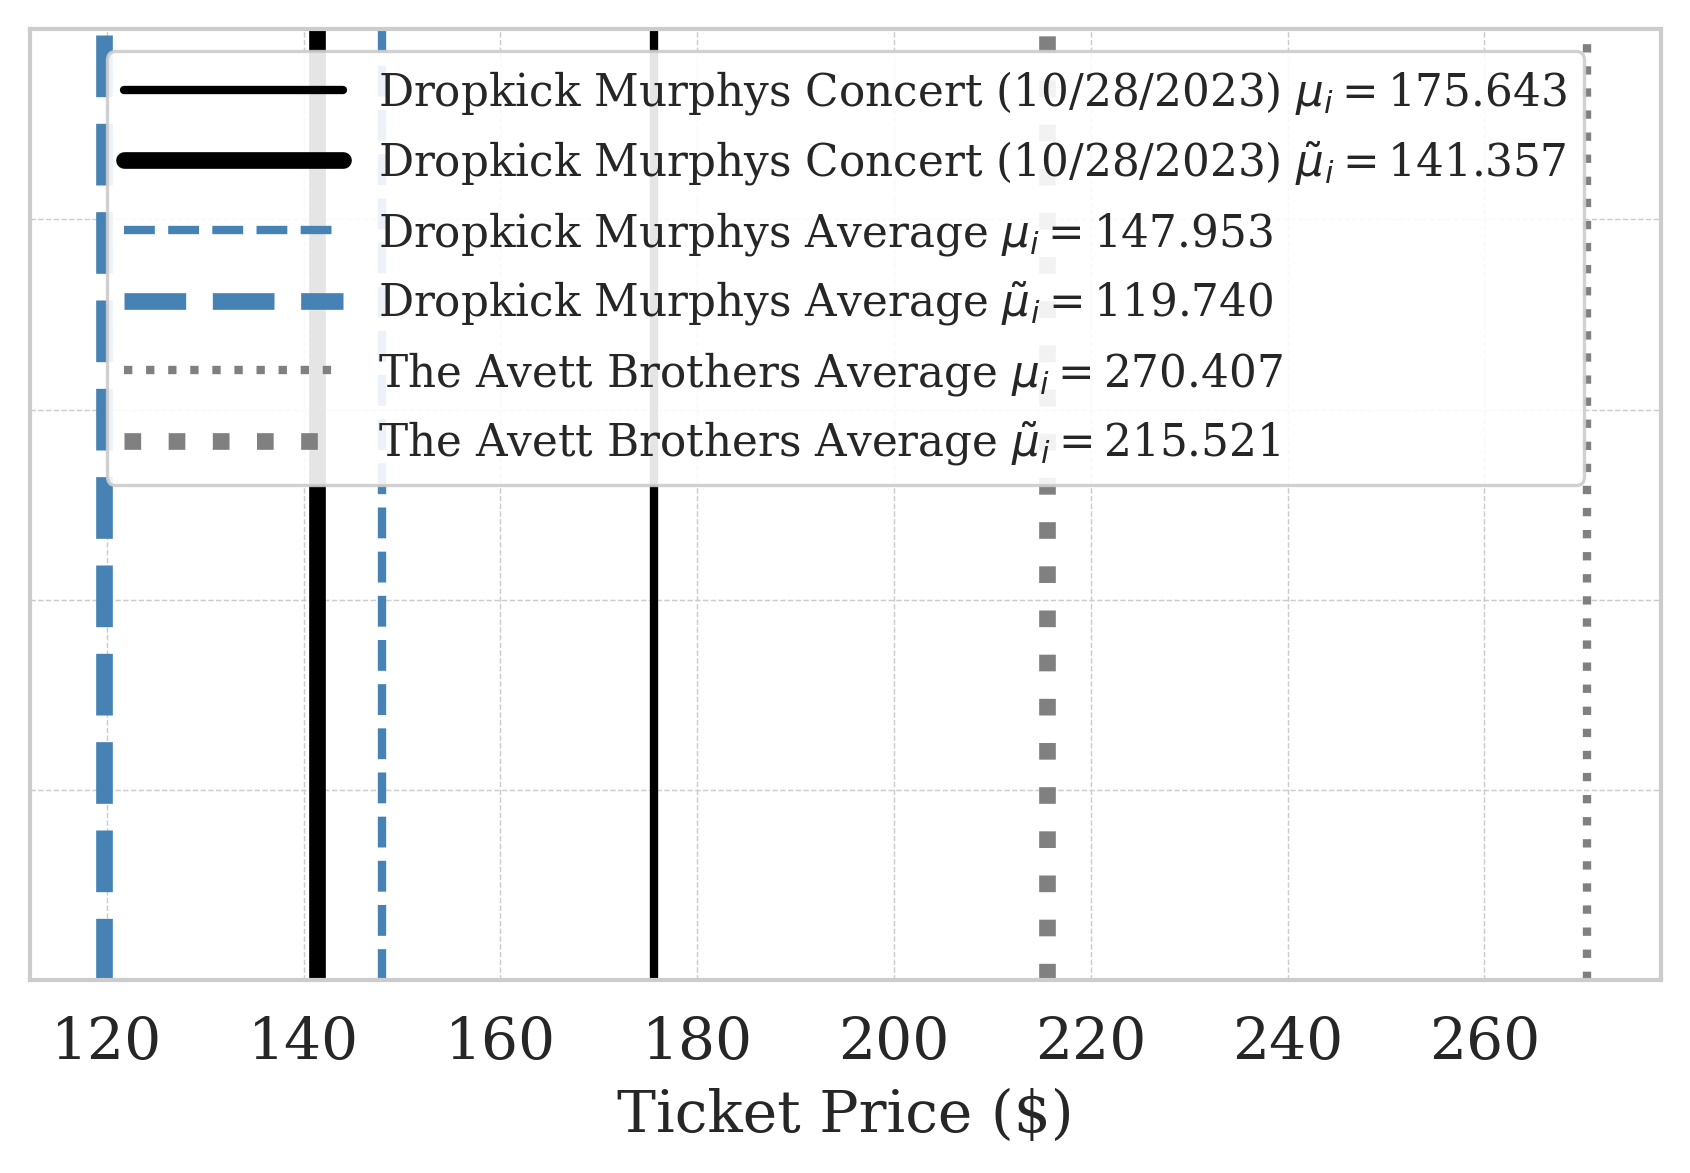

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from scipy.stats import beta
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

fsize = 14

# Define muted blue-gray-black color palette
line_colors = {
    "Event Time Series": "black",
    f"{art1} Average": "#4682B4",
    f"{art2} Average": "grey",
    f"{art1} Median": "#4682B4",
    f"{art2} Median": "grey"
}

# Load full dataset
full_df = load_df_from_file(verbose=False)

# Create subsets:
# 1. Single event time series by event_id
df_event = full_df[full_df.event_id == 8284]
display(df_event)

# 2. Averages (mean) for each act
df_bey_avg = full_df[full_df.act == art1].groupby("act").mean().reset_index()
df_sheeran_avg = full_df[full_df.act == art2].groupby("act").mean().reset_index()

# 3. Medians for each act (if needed)
df_bey_med = full_df[full_df.act == art1].groupby("act").median().reset_index()
df_sheeran_med = full_df[full_df.act == art2].groupby("act").median().reset_index()

# Helper function to plot beta PDFs and add vertical lines for mean and median
def plot_series(ax, data, label, linestyle, color):
    if data.empty:
        return
    # Extract parameters
    mean_val = data.average_price.iloc[0]
    median_val = data.median_price.iloc[0]
    min_value = data.lowest_price.iloc[0]
    max_value = data.highest_price.iloc[0]
    alpha_val = data.alpha.iloc[0]
    beta_val = data.beta.iloc[0]
    
    # Generate x values over the price range and scale appropriately
    x = np.linspace(min_value, max_value, 500)
    scale_factor = max_value - min_value
    x_scaled = (x - min_value) / scale_factor
    
    # Ensure positive alpha and beta values
    alpha_val = max(alpha_val, 0.001)
    beta_val = max(beta_val, 0.001)
    
    # Compute the scaled beta distribution PDF
    pdf_vals = beta.pdf(x_scaled, alpha_val, beta_val) / scale_factor
    
    # Plot the PDF curve
    # ax.plot(x, pdf_vals, linestyle=linestyle, color=color, linewidth=2, label=label)
    
    # Add vertical lines for average and median of this series
    ax.axvline(mean_val, color=color, linestyle=linestyle, linewidth=2,
               label=f"{label}" + r" $\mu_i = $" + f"{mean_val:.3f}")
    ax.axvline(median_val, color=color, linestyle=linestyle, linewidth=4,
               label=f"{label}" + r" $\tilde{\mu}_{i} = $" + f"{median_val:.3f}")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot each series using distinct line styles for clear differentiation in black and white
plot_series(ax, df_event, "Dropkick Murphys Concert (10/28/2023)", linestyle='-', color=line_colors["Event Time Series"])
plot_series(ax, df_bey_avg, f"{art1} Average", linestyle='--', color=line_colors[f"{art1} Average"])
plot_series(ax, df_sheeran_avg, f"{art2} Average", linestyle=':', color=line_colors[f"{art2} Average"])

# Set labels, legend, and grid styling
ax.set_xlabel("Ticket Price (\$)", fontsize=fsize)
ax.set_ylabel("", fontsize=fsize)
ax.tick_params(axis='y', labelleft=False)  # hides labels but keeps ticks for grid lines

#ax.set_xlim(250, 3000)
plt.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)

#plt.grid(True, which='none', linestyle='--', linewidth=0.125, alpha=1)
#plt.grid()
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

# To avoid duplicate legend entries, filter them
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=10.5, loc='upper center',
          facecolor='white', frameon=True, handlelength=5, framealpha=.9)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('dropkick_murphys_avett_brothers_stats_comparison.eps', format='eps', dpi=300, bbox_inches='tight')
#plt.grid(True, which='both', linestyle='--', linewidth=0.125, alpha=1)
plt.show()

